In [ ]:
# import necessary imports
import numpy as np
import matplotlib as plt

In [93]:
def get_batch(input, batch_size, chunk_size):
    """ splits the input text into batches of chunks, returns input and target batches"""
    input_batch = []
    target_batch = []
    idx = np.random.randint(0,len(input)-(chunk_size+1),size=batch_size)
    for i in range(0,len(idx)-1):
        input_batch.append(input[idx[i]:idx[i]+chunk_size])
        target_batch.append(input[idx[i]+1:idx[i]+(chunk_size+1)])
    
    input_batch = np.array(input_batch)
    target_batch = np.array(target_batch)

    return input_batch, target_batch

In [94]:
""" Code for decoding """
with open (r"vocab_train.txt", 'r') as f:
   vocab_train = eval(f.read())

vocab = vocab_train
indices = np.arange(0,len(vocab),1)
inidces = indices.astype(int)
indices = indices.tolist()
key_byte = dict(zip(vocab, indices))
value_byte = dict(zip(indices,vocab))

with open (r"indices_text.txt", 'r') as f:
  indices_text = eval(f.read())


def decode_characters(input):
    """Decodes a list of indices back to their corresponding characters
    given the abive defined vocabulary"""

    decoded = [] #given the input, we will decode it back to characters
    for i in range(0,len(input)):
        decoded.append(value_byte[input[i]]) #using the translation dctionary: value_byte

    #makes it prettier by joining list to actual words and replacing underscores with spaces
    decoded = ''.join(decoded)
    decoded = decoded.replace('_', ' ')
    return decoded

In [95]:
class neural_embedding:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.token_embedding_table = np.random.rand(vocab_size, vocab_size) # weights


    def calculate_softmax(self, x):
        """
        Takes input array x and returns softmax along the last axis (axis=-1).
        Works for arrays of any shape: (a, b, c) will softmax along c.
        """
        softmax = np.zeros_like(x)
        dima, dimb, _ = x.shape
        for a in range(dima):
            for b in range(dimb):
                # subtract max to prevent overflow
                exps = np.exp(x[a][b] - np.max(x[a][b]))
                # calculate softmax
                softmax[a][b] = exps / np.sum(exps)
        return softmax


    def calculate_cross_entropy(self, target, y_hat):
        """
        Takes target (y_hatless) and prediction (y_hat) and computes cross entropy loss.
        """
        # get vocab_size
        _, _, vocab_size = y_hat.shape   
        y_hat = self.calculate_softmax(y_hat)
        y_hat_flat = y_hat.reshape(-1, vocab_size)
        target_flat = target.reshape(-1)
        # one-hot encode targets
        target_hot = np.eye(vocab_size)[target_flat]
                
        # Clip predictions to avoid log(0)
        y_hat_flat = np.clip(y_hat_flat, 1e-15, 1.0) 
        loss = -np.sum(target_hot*np.log(y_hat_flat))
        return loss
    
    def forward(self, idx, targets=None):
        """
        Implements forward pass with an unnecessary logitte function 
        which i only did not delete because now I'm emotionally attached.
        Args:
            idx(np.array): (B,T) numpy array of integers
            targets(np.array): (B,T) numpy array of integers
        Returns:
            input_logits(np.array)
            sometimes also: targets(np.array)
        """
        batch_size, chunk_size = idx.shape

        #initalize logits
        input_logits = np.zeros((batch_size, chunk_size, (self.token_embedding_table[0].size)))

        for batch in range(batch_size):
            for chunk in range(chunk_size):
                # (B,T,C) b=batch_size, t="time"=chunk_size, c=vocab_size
                input_logits[batch][chunk] = self.token_embedding_table[idx[batch][chunk]]
                    
        if targets is not None:
            loss = self.calculate_cross_entropy(targets, input_logits) #if the forward function is called in the training, calculate the loss
            return input_logits, loss

        return input_logits

    def generate(self, idx, max_new_tokens):
            """ generates max_new_tokens new words based on the embedding """
            collect = idx.tolist()
            for _ in range(max_new_tokens):
                logits = self.forward(idx)
                probs = self.calculate_softmax(logits)
                probs = probs[:, -1, :]  # take the last time step
                idx_next = np.random.multinomial(1, probs[0])
                idx_next = np.where(idx_next==1)
                idx[0][:-1] = idx[0][1:]  # shift the array to the left
                idx[0][-1] = idx_next[0]
                collect[0].append(idx_next[0][0].tolist())

            return collect
    
    def backward(self, input, targets, input_logits):
        """ backward step, calculates the error signal and returns the corresponding gradient"""
    
        # need to do the same reshaping as we did for cross entropy
        targets_flat = targets.reshape(-1)
        inputs_flat = input.reshape(-1)
        one_hot_targets = np.eye(self.vocab_size)[targets_flat]
        one_hot_inputs =np.eye(self.vocab_size)[inputs_flat]

        # reshape to B*C, T
        soft_input = self.calculate_softmax(input_logits) # WE ARE UNSURE IF SOFTMAX IS NEEDED HERE
        soft_input = soft_input.reshape(soft_input.shape[0]*soft_input.shape[1], soft_input.shape[2])
        
        # derivation of softmax & crossentropy
        delta = soft_input - one_hot_targets
        
        # want shape (vocab_size, vocab_size) for matrix multiplication, but with correct indices (use one-hot inputs for that)
        delta_indexed = np.dot(one_hot_inputs.transpose(),delta)

        # compute gradient for weight matrix: dot product between the transpose of the to layer and delta vector computed above
        gradient  =   delta_indexed @ self.token_embedding_table.T # WE ARE UNSURE ABOUT WHETHER THIS STEP IS NECESSARY, AND IF THE ORDER OF THE MATMULT + TRANSPOSE IS CORRECT
    
        return gradient

    

In [109]:
def train(model, text,  train_step):
    """ train step, performs a forward step and then passes the loss to the backward step, adapts the embedding table"""
    batch_size = 32
    chunk_size = 8

    losses = []
    
    for steps in range(train_step): 
        # sample batch of data
        xb, yb = get_batch(text, batch_size, chunk_size) 

        # get logits and loss
        logits, loss = model.forward(xb, yb)
        losses.append(float(loss.copy()))

        # pass the logits to get the gradient
        gradient = model.backward(xb, yb, logits)
        
        # parameter update using simple SGD
        # we tried using Adam before (numpy and torch version), did not improve our results
        model.token_embedding_table = model.token_embedding_table - (gradient  * 0.01) 
    return losses
        

In [110]:
# the vocab size is the length of our vocab list
vocab_size = len(vocab_train)

# initialize our model
my_neural_embedding = neural_embedding(vocab_size)


# train the model
loss = train(my_neural_embedding, indices_text, 5000)

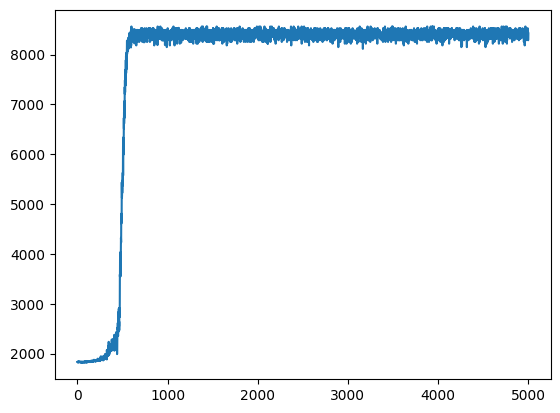

In [111]:
y = np.arange(1, len(loss)+1)
plt.plot(y, loss)
plt.show()

In [112]:
our_output = my_neural_embedding.generate(np.array([[1,5]]), max_new_tokens=10)

decoded = decode_characters(our_output[0])
print(decoded)

therefore polonius the , the , the , the , the , 


C:\Users\alice\AppData\Local\Temp\ipykernel_41380\2535527461.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx[0][-1] = idx_next[0]
